# EC601 - AI in Healthcare - "FerriMetric"
<br>
FerriMetric is an AI-based tool that stands at the intersection of Nutrition Science and Artificial Intelligence. This tool has two main objectives. <br> One, it provides a numeric metric to assess the bioavailability of iron in patients. <br> Two, it takes 3 parameters from the patients' bloodwork to calculate the Transferrin Saturation, which is a percentage of iron-binding sites on transferrin proteins in the body. <br>
<br>
The main target users of FerriMetric would be doctors or nutritionists seeking to automate the process of iron assessment in patients by using hard numeric values to make comparative analyses and diagnoses. 

## PART-1: Nutrition analysis from diet - Bioavailability of iron

What does bioavailability mean? <br>
Put simply, bioavailability indicates the amount of iron that is actually available for absorption by the body. This is an essential metric because iron that is consumed through diet may not always be fully absorbed by the body. We cannot safely assume that just because our meal had iron in it as a nutrient, our body absorbed all of it. Apart from our intake of iron through diet or supplements, we must pay attention to our body's ability to absorb the iron that we are giving it. <br> 
Suppose we eat x mgs of iron in one meal. Does our body absorb all x mgs of it? Is some of it lost or not absorbed? If so, why? How much of the iron is available for our body to absorb? Are some sources of iron easier to absorb than others? <br>
These are the questions that FerriMetric takes into consideration to provide a number, a calculated metric, that quantifies how much iron is available for absorption by the body. 

https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DR1IFF.htm <br>
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0111824
https://figshare.com/articles/dataset/_Estimation_of_Dietary_Iron_Bioavailability_from_Food_Iron_Intake_and_Iron_Status_/1223957
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_FETIB.htm#SEQN
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DR1IFF.htm#DR1CCMTX
https://www.healthline.com/nutrition/increase-iron-absorption
https://pubmed.ncbi.nlm.nih.gov/10799377/

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO

In [152]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import json

### The dataset for this project: NHANES Dietary Interview https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DR1IFF.htm

In [153]:
dfn = pd.read_sas('nutrients.XPT')

### Initial preprocessing and data cleaning

In [154]:
dfn.head(10)

,SEQN,WTDRD1PP,WTDR2DPP,DR1ILINE,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1CCMNM,DR1CCMTX,DR1_020,DR1_030Z,DR1FS,DR1_040Z,DR1IFDCD,DR1IGRMS,DR1IKCAL,DR1IPROT,DR1ICARB,DR1ISUGR,DR1IFIBE,DR1ITFAT,DR1ISFAT,DR1IMFAT,DR1IPFAT,DR1ICHOL,DR1IATOC,DR1IATOA,DR1IRET,DR1IVARA,DR1IACAR,DR1IBCAR,DR1ICRYP,DR1ILYCO,DR1ILZ,DR1IVB1,DR1IVB2,DR1INIAC,DR1IVB6,DR1IFOLA,DR1IFA,DR1IFF,DR1IFDFE,DR1ICHL,DR1IVB12,DR1IB12A,DR1IVC,DR1IVD,DR1IVK,DR1ICALC,DR1IPHOS,DR1IMAGN,DR1IIRON,DR1IZINC,DR1ICOPP,DR1ISODI,DR1IPOTA,DR1ISELE,DR1ICAFF,DR1ITHEO,DR1IALCO,DR1IMOIS,DR1IS040,DR1IS060,DR1IS080,DR1IS100,DR1IS120,DR1IS140,DR1IS160,DR1IS180,DR1IM161,DR1IM181,DR1IM201,DR1IM221,DR1IP182,DR1IP183,DR1IP184,DR1IP204,DR1IP205,DR1IP225,DR1IP226
0,109263.00,7619.48,17808.07,12.00,1.00,14.00,2.00,2.00,4.00,6.00,1.00,0.00,0.00,68400.00,3.00,1.00,1.00,28320300.00,199.50,114.00,12.11,5.07,2.13,1.60,4.95,1.47,2.10,0.95,25.00,0.49,0.00,1.00,16.00,19.00,174.00,0.00,0.00,214.00,0.24,0.17,2.96,0.24,27.00,0.00,27.00,27.00,44.50,0.27,0.00,14.80,0.30,38.00,43.00,106.00,22.00,1.31,1.03,0.06,649.00,335.00,16.60,0.00,0.00,0.00,174.93,0.00,0.00,0.00,0.00,0.00,0.05,0.93,0.45,0.11,1.94,0.04,0.00,0.84,0.09,0.00,0.01,0.00,0.00,0.00
1,109263.00,7619.48,17808.07,10.00,1.00,14.00,2.00,2.00,4.00,6.00,1.00,0.00,0.00,64800.00,6.00,8.00,1.00,91746110.00,20.00,101.00,2.20,12.03,10.40,0.70,5.09,2.66,1.25,0.53,1.00,0.38,0.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.02,0.03,0.94,0.02,11.00,0.00,11.00,11.00,6.60,0.04,0.00,0.00,0.00,0.90,17.00,40.00,16.00,0.17,0.29,0.09,24.00,71.00,0.50,1.00,11.00,0.00,0.35,0.03,0.01,0.07,0.08,0.92,0.36,0.68,0.47,0.01,1.23,0.01,0.00,0.52,0.01,0.00,0.00,0.00,0.00,0.00
2,109263.00,7619.48,17808.07,4.00,1.00,14.00,2.00,2.00,4.00,6.00,1.00,0.00,0.00,43200.00,2.00,8.00,2.00,58106210.00,238.00,633.00,27.11,79.33,8.52,5.50,23.06,10.63,6.21,4.00,40.00,1.98,0.00,145.00,164.00,0.00,219.00,0.00,4558.00,138.00,0.93,0.46,9.10,0.19,221.00,124.00,95.00,307.00,39.00,1.00,0.00,3.30,0.00,15.90,447.00,514.00,57.00,5.90,3.19,0.25,1423.00,409.00,47.40,0.00,0.00,0.00,102.75,0.24,0.19,0.13,0.34,0.42,1.43,5.47,2.04,0.28,5.68,0.09,0.01,3.48,0.42,0.01,0.03,0.01,0.01,0.00
3,109263.00,7619.48,17808.07,9.00,1.00,14.00,2.00,2.00,4.00,6.00,1.00,0.00,0.00,59400.00,6.00,1.00,1.00,64104010.00,209.00,99.00,0.19,23.71,21.17,0.40,0.52,0.05,0.01,0.08,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33.00,0.01,0.04,0.05,0.03,5.00,0.00,5.00,5.00,3.80,0.00,0.00,80.70,0.00,0.00,15.00,13.00,10.00,0.13,0.01,0.01,10.00,203.00,0.20,0.00,0.00,0.00,184.27,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.01,0.00,0.00,0.07,0.01,0.00,0.00,0.00,0.00,0.00
4,109263.00,7619.48,17808.07,13.00,1.00,14.00,2.00,2.00,4.00,6.00,1.00,0.00,0.00,68400.00,3.00,1.00,1.00,11710801.00,124.00,123.00,3.55,13.83,13.02,0.00,5.92,1.56,2.40,1.32,2.00,1.81,1.81,92.00,92.00,0.00,0.00,0.00,0.00,0.00,0.32,0.25,2.00,0.31,43.00,45.00,0.00,74.00,36.00,0.71,0.71,11.80,1.50,4.50,115.00,94.00,24.00,1.66,1.43,0.12,45.00,155.00,2.70,0.00,0.00,0.00,99.78,0.00,0.00,0.62,0.43,0.02,0.01,0.32,0.15,0.01,2.38,0.01,0.00,1.21,0.11,0.00,0.00,0.00,0.00,0.00
5,109263.00,7619.48,17808.07,6.00,1.00,14.00,2.00,2.00,4.00,6.00,1.00,0.00,0.00,52200.00,6.00,8.00,2.00,54304020.00,10.00,49.00,1.09,5.94,0.45,0.20,2.27,0.53,0.57,1.01,0.00,0.22,0.00,1.00,2.00,0.00,6.00,2.00,0.00,3.00,0.06,0.03,0.61,0.02,15.00,13.00,3.00,24.00,0.90,0.03,0.00,0.00,0.00,0.90,14.00,20.00,3.00,0.49,0.12,0.01,97.00,16.00,1.40,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.00,0.00,0.01,0.35,0.14,0.00,0.57,0.00,0.00,0.94,0.07,0.00,0.00,0.00,0.00,0.00
6,109263.00,7619.48,17808.07,8.00,1.00,14.00,2.00,2.00,4.00,6.00,1.00,0.00,0.00,59400.00,6.00,1.00,1.00,57124200.00,11.67,45.00,0.63,9.45,4.02,0.60,0.58,0.08,0.28,0.16,0.00,0.07,0.00,0.00,1.00,4.00,6.00,0.00,0.00,96.00,0.07,0.06,0.77,0.09,16.00,14.00,2.00,26.00,1.00,0.10,0.10,2.60,0.60,0.30,20.00,13.00,5.00,1.20,0.10,0.02,50.00,18.00,1.00,1.00,7.00,0.00,0.78,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.02,0.00,0.27,0.01,0.00,0.14,0.03,0.00,0.00,0.00,0.00,0.00
7,109263.00,

In [155]:
dfn.shape # checking dataset size

(183910, 84)

In [156]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [157]:
dfn.isnull().sum() # checking the number of null values

SEQN           0
WTDRD1PP       0
WTDR2DPP       0
DR1ILINE       0
DR1DRSTZ       0
            ... 
DR1IP184    1404
DR1IP204    1404
DR1IP205    1404
DR1IP225    1404
DR1IP226    1404
Length: 84, dtype: int64

In [158]:
# dropping unnecessary columns
cols = ['DR1DBIH', 'DR1FS']
dfn = dfn.drop(columns = cols)

In [159]:
dfn = dfn.dropna() # dropping null values

In [160]:
dfn.shape # checking size after cleaning

(182497, 82)

### On what basis is this bioavailability calculated? 
The absorption of iron in our body is also dependent on other nutrients consumed along with it. Those that help in the absorption of iron are called Enhancers and those that inhibit the same are called Inhibitors. These are also nutrients that are a part of our overall diet. In fact, some of these are even essential nutrients that our body needs. However, as essential as they may be, they do have an inhibitory effect on the absorption of iron in the human body. <br>
These are some prominent and researched enhancers and inhibitors that our model takes into consideration. <br>
<b>Enhancers:</b> Vitamin C, vitamin A, meat, poultry, seafood, beta-carotene <br>
<b>Inhibitors:</b> Phytate (or phytic acid), calcium, polyphenols, alcohol, caffeine <br>
<br>
Apart from these Enhancers and Inhibitors, it is also important to look at the type of iron consumed. There are 2 main types of iron in diet: <b>heme and non-heme</b>. <br>
Heme iron is the iron found in animal-based sources. Non-heme iron is the iron from plant-based sources. Studies have shown that heme iron is easier to absorb and is a more complete source of iron than non-heme iron. Our body can absorb upto 40% of heme iron. <br>
https://www.healthline.com/nutrition/increase-iron-absorption#excessive-iron-risks

In [161]:
# extracting just the necessary columns of enhancers and inhibitors
cols1 = ['SEQN', 'DR1CCMTX', 'DR1IVARA', 'DR1IACAR', 'DR1IBCAR', 'DR1IVC', 'DR1ICALC', 
         'DR1IIRON', 'DR1ICAFF', 'DR1IALCO']

In [162]:
dfn1 = dfn[cols1]

In [163]:
col_names = ['Seq_num', 'Food type', 'Vit-A (mg)', 'Alpha-carotene (mg)', 'Beta-carotene (mg)', 'Vit-C (mg)', 
             'Calcium (mg)', 'Iron (mg)', 'Caffeine (mg)', 'Alcohol (mg)']

In [164]:
dfn1.columns = col_names

In [165]:
dfn1.head() # inspecting the new dataset

,Seq_num,Food type,Vit-A (mg),Alpha-carotene (mg),Beta-carotene (mg),Vit-C (mg),Calcium (mg),Iron (mg),Caffeine (mg),Alcohol (mg)
0,109263.00,0.00,16.00,19.00,174.00,14.80,43.00,1.31,0.00,0.00
1,109263.00,0.00,2.00,0.00,0.00,0.00,17.00,0.17,1.00,0.00
2,109263.00,0.00,164.00,0.00,219.00,3.30,447.00,5.90,0.00,0.00
3,109263.00,0.00,0.00,0.00,0.00,80.70,15.00,0.13,0.00,0.00
4,109263.00,0.00,92.00,0.00,0.00,11.80,115.00,1.66,0.00,0.00


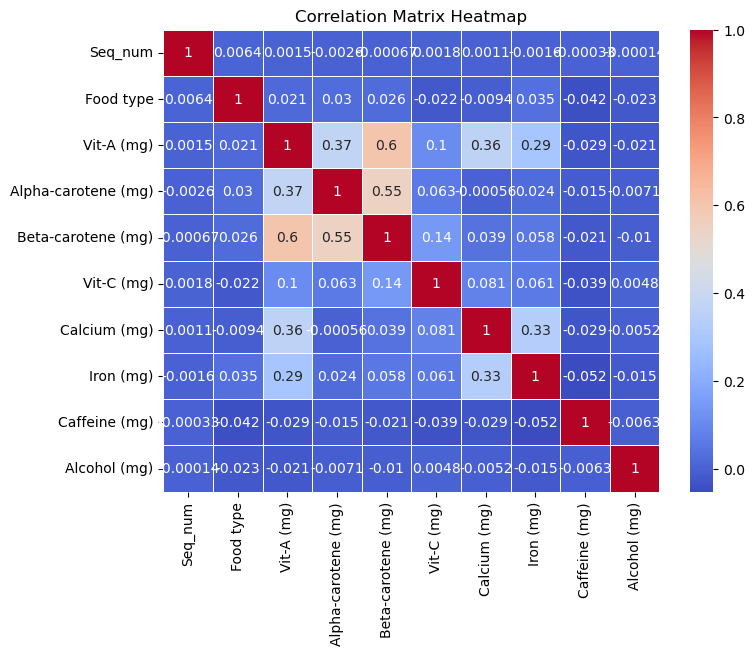

In [166]:
# correlation heatmap to see the relation between different features
cor_mat = dfn1.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Feature Engineering
As seen from the heat map, there is no relation between any of these nutrients. This is expected. These nutrients are either enhancers or inhibitors that directly affect the absorption of iron in the body. In order to establish a relation between them, a new feature is created to estimate the bioavailability of iron. <br>
Hallberg and Hulthén proposed a formula to calculate the bioavailability of iron: <br>
<b>Estimated Iron Absorption = [Iron Content (mg) - Inhibitors] x Enhancers </b> <br>
Although this formula provides a metric for assessment, it does not take into consideration many other factors. Here, this formula was modified to include some more factors that can provide a more holistic metric. <br>
<b>Estimated Iron Absorption = (Total Iron Content x Heme Iron Adjustment) x (1 + Enhancers - Inhibitors)</b> <br>
This improved formula in our analysis takes into consideration the Heme-iron factor. If the meal included any form of animal-based products such as meat, seafood or poultry, a factor of 2 was assigned. If the meal did not involve any form of animal products, a factor of 1 is assigned. This is done to account for the increased absorption of heme-iron when compared with non-heme iron.

In [167]:
pd.set_option('display.float_format', '{:.10f}'.format)

In [168]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [169]:
dfn1.head(20)

,Seq_num,Food type,Vit-A (mg),Alpha-carotene (mg),Beta-carotene (mg),Vit-C (mg),Calcium (mg),Iron (mg),Caffeine (mg),Alcohol (mg)
0,109263.00,0.00,16.00,19.00,174.00,14.80,43.00,1.31,0.00,0.00
1,109263.00,0.00,2.00,0.00,0.00,0.00,17.00,0.17,1.00,0.00
2,109263.00,0.00,164.00,0.00,219.00,3.30,447.00,5.90,0.00,0.00
3,109263.00,0.00,0.00,0.00,0.00,80.70,15.00,0.13,0.00,0.00
4,109263.00,0.00,92.00,0.00,0.00,11.80,115.00,1.66,0.00,0.00
5,109263.00,0.00,2.00,0.00,6.00,0.00,14.00,0.49,0.00,0.00
6,109263.00,0.00,1.00,4.00,6.00,2.60,20.00,1.20,1.00,0.00
7,109263.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00
8,109263.00,0.00,96.00,0.00,0.00,12.40,121.00,1.75,0.00,0.00
9,109263.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00


In [170]:
# heme-iron adjustment
dfn1 = dfn1.copy()
dfn1['heme-iron-adj'] = np.where(dfn1['Food type'] == 12.00, 2, 1)

In [171]:
# counting the occurences of heme-iron 
dfn1['heme-iron-adj'].value_counts()

1    177827
2      4670
Name: heme-iron-adj, dtype: int64

In [172]:
dfn1['Alcohol (mg)'] = dfn1['Alcohol (mg)'] * 1000

In [173]:
dfn1['Vit-A (mg)'] = dfn1['Vit-A (mg)'] / 1000

In [174]:
dfn1['Alpha-carotene (mg)'] = dfn1['Alpha-carotene (mg)'] / 1000

In [175]:
dfn1['Beta-carotene (mg)'] = dfn1['Beta-carotene (mg)'] / 1000

### Calculating the Estimated Iron feature that gives us the bioavailability
Estimated iron = (Iron (mg) * heme-iron-adj) * (1+ [ (Vit-A (mg) + Alpha-carotene (mg) + Beta-carotene (mg) + Vit-C (mg)) - (Calcium (mg) + Caffeine (mg) + Alcohol (mg)) ] 

In [176]:
dfn1['enhancers'] = dfn1['Vit-A (mg)'] + dfn1['Alpha-carotene (mg)'] + dfn1['Beta-carotene (mg)'] + dfn1['Vit-C (mg)']

In [177]:
dfn1['inhibitors'] = dfn1['Calcium (mg)'] + dfn1['Caffeine (mg)'] + dfn1['Alcohol (mg)']

In [178]:
dfn1['abs-factor'] = dfn1['Iron (mg)'] * dfn1['heme-iron-adj']

In [179]:
dfn1['subtract'] = dfn1['enhancers'] - dfn1['inhibitors']

In [180]:
dfn1['Estimated-iron'] = dfn1['abs-factor'] * (1 + dfn1['subtract'])

In [181]:
dfn1.head()

,Seq_num,Food type,Vit-A (mg),Alpha-carotene (mg),Beta-carotene (mg),Vit-C (mg),Calcium (mg),Iron (mg),Caffeine (mg),Alcohol (mg),heme-iron-adj,enhancers,inhibitors,abs-factor,subtract,Estimated-iron
0,109263.00,0.00,0.02,0.02,0.17,14.80,43.00,1.31,0.00,0.00,1,15.01,43.00,1.31,-27.99,-35.36
1,109263.00,0.00,0.00,0.00,0.00,0.00,17.00,0.17,1.00,0.00,1,0.00,18.00,0.17,-18.00,-2.89
2,109263.00,0.00,0.16,0.00,0.22,3.30,447.00,5.90,0.00,0.00,1,3.68,447.00,5.90,-443.32,-2609.67
3,109263.00,0.00,0.00,0.00,0.00,80.70,15.00,0.13,0.00,0.00,1,80.70,15.00,0.13,65.70,8.67
4,109263.00,0.00,0.09,0.00,0.00,11.80,115.00,1.66,0.00,0.00,1,11.89,115.00,1.66,-103.11,-169.50


### Fitting the Machine Learning model - Random Forest

In [182]:
x = dfn1[['Vit-A (mg)', 'Alpha-carotene (mg)', 'Beta-carotene (mg)', 'Vit-C (mg)', 
             'Calcium (mg)', 'Iron (mg)', 'Caffeine (mg)', 'Alcohol (mg)', 'heme-iron-adj']]
y = dfn1['Estimated-iron']

# x is input to the mode, y is the expected output which in this case is the bioavailability of iron

In [183]:
# splitting training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [184]:
# Initialize the Random Forest Regressor
FerriMetric = RandomForestRegressor(n_estimators=150, random_state=42)

# Train the model on the training data
FerriMetric.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = FerriMetric.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 386865.7516564007
Mean Absolute Error (MAE): 12.916015436336268
R-squared (R2): 0.9844916248620221


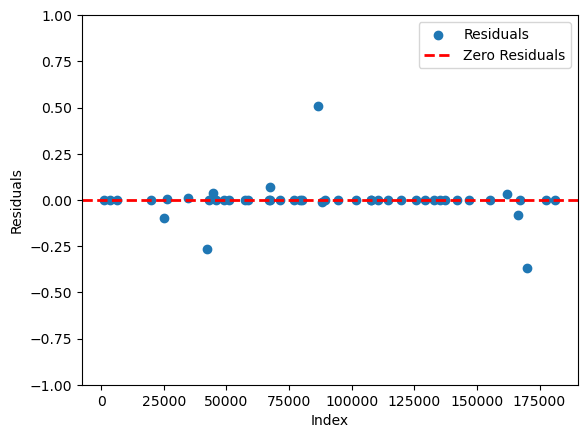

In [185]:
start_index = 100
end_index = 150

# Subset the data
y_test_subset = y_test.iloc[start_index:end_index]
y_pred_subset = y_pred[start_index:end_index]
residuals = y_pred_subset - y_test_subset

# Set the y-axis limits to make the zero line more centered
plt.scatter(y_test_subset.index, residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Residuals')

# Adjust the y-axis limits to bring the zero line down
plt.ylim(-1, 1)

plt.xlabel('Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

### Saving the model for future predictions

In [186]:
joblib.dump(FerriMetric, 'FerriMetric.joblib')

['FerriMetric.joblib']

In [187]:
FerriMetric_loaded = joblib.load('FerriMetric.joblib')

## PART-2: Transferrin Saturation from a patient's bloodwork
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_FETIB.htm#Laboratory_Method_Files
https://www.uptodate.com/contents/hereditary-hemochromatosis-beyond-the-basics/print
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1466848/#:~:text=For%20example%2C%20persons%20with%20increased,of%20iron%20or%20red%20meat. <br>



Transferrin Saturation is a value calculated in a medical lab and is mainly used for the assessment of iron levels. Transferrin is a protein found in the blood and it has iron-binding sites on it. The amount of iron that is capable of binding to those sites is Transferrin Saturation (TS). It is represented by a percentage. For instance, a TS value of 20% would indicate that 20% of iron-binding sites on the protein Transferrin are occupied by iron. A low value of TS is an indicator of iron-deficiency anaemia and a higher value of TS would indicate an iron overload condition hemochromatosis. 

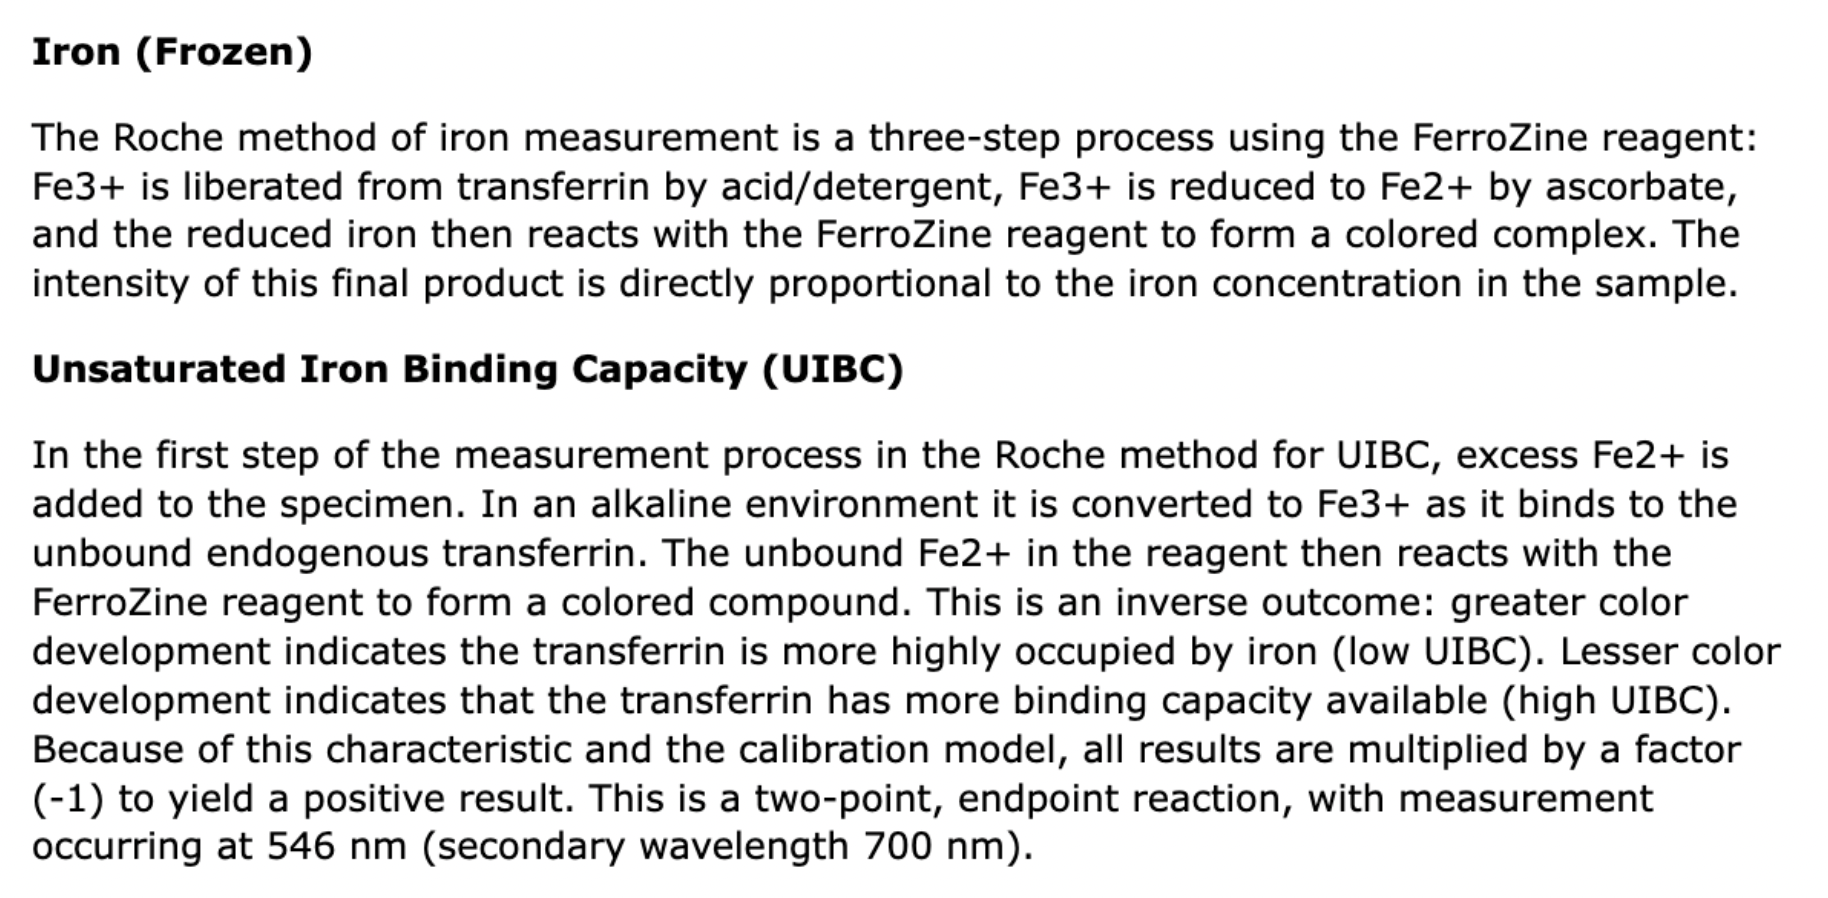
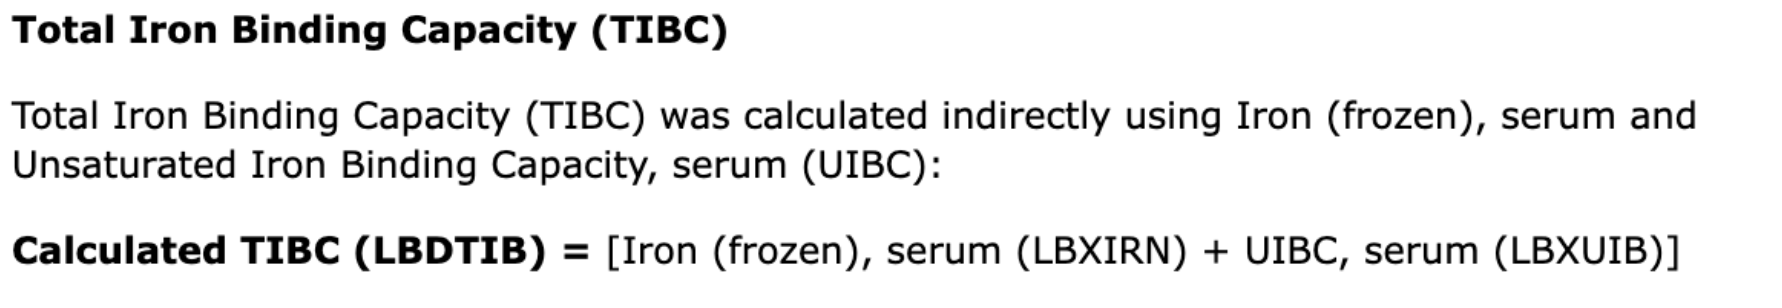

In [188]:
df = pd.read_sas('iron-serum.XPT')

### Exploratory data analyses, preprocessing and cleaning

In [189]:
columns = ['Seq_num', 'Iron-Serum (ug/dL)', 'Iron-Serum (umol/L)', 'UIBC (ug/dL)', 'UIBC Comment Code', 'UIBC (umol/L)', 'TIBC (ug/dL)', 'TIBC (umol/L)', 'Transferrin sat (%)']

In [190]:
df.columns = columns

In [191]:
df.head()

,Seq_num,Iron-Serum (ug/dL),Iron-Serum (umol/L),UIBC (ug/dL),UIBC Comment Code,UIBC (umol/L),TIBC (ug/dL),TIBC (umol/L),Transferrin sat (%)
0,109264.00,80.00,14.30,326.00,0.00,58.39,406.00,72.71,20.00
1,109266.00,50.00,9.00,374.00,0.00,66.98,424.00,75.94,12.00
2,109271.00,64.00,11.50,220.00,0.00,39.40,284.00,50.86,23.00
3,109273.00,210.00,37.60,85.00,0.00,15.22,295.00,52.83,71.00
4,109274.00,77.00,13.80,179.00,0.00,32.06,256.00,45.85,30.00


In [192]:
df.shape

(10409, 9)

In [193]:
df.isnull().sum()

Seq_num                  0
Iron-Serum (ug/dL)     904
Iron-Serum (umol/L)    904
UIBC (ug/dL)           949
UIBC Comment Code      949
UIBC (umol/L)          949
TIBC (ug/dL)           956
TIBC (umol/L)          956
Transferrin sat (%)    956
dtype: int64

In [194]:
df = df.dropna() # dropping null values

In [195]:
# extracting only the necessary columns with uniform units of measurement
needed = ['Seq_num', 'Iron-Serum (ug/dL)', 'UIBC (ug/dL)', 'TIBC (ug/dL)', 'Transferrin sat (%)']

In [196]:
df1 = df[needed]

In [197]:
df1.head()

,Seq_num,Iron-Serum (ug/dL),UIBC (ug/dL),TIBC (ug/dL),Transferrin sat (%)
0,109264.00,80.00,326.00,406.00,20.00
1,109266.00,50.00,374.00,424.00,12.00
2,109271.00,64.00,220.00,284.00,23.00
3,109273.00,210.00,85.00,295.00,71.00
4,109274.00,77.00,179.00,256.00,30.00


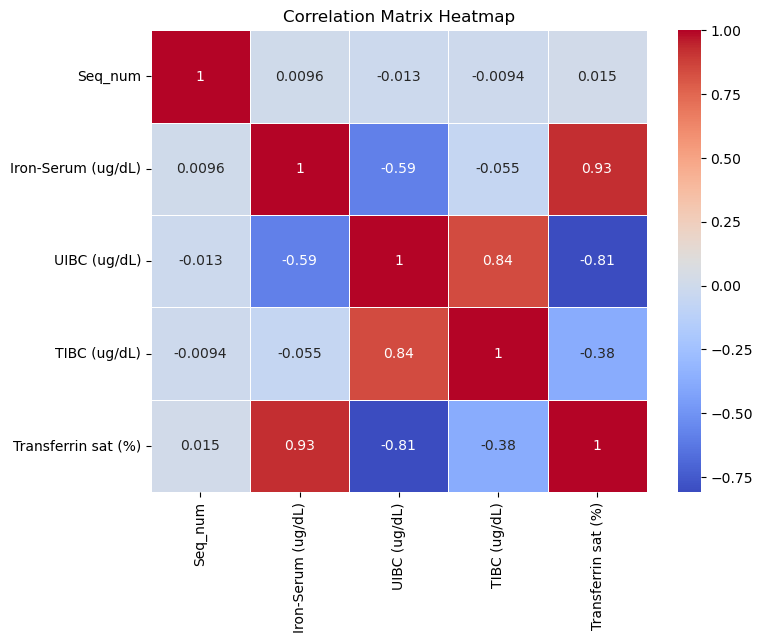

In [198]:
# plotting correlation matrix to see relation between features
cor_mat = df1.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Transferrin sat seems to depend on Iron-Serum. TIBC and UIBC have a degree of correlation.

### Fitting the Machine Learning model - Random Forest

In [199]:
x = df1[['Iron-Serum (ug/dL)', 'UIBC (ug/dL)', 'TIBC (ug/dL)']]
y = df1['Transferrin sat (%)']

In [200]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [201]:
TraSat = RandomForestRegressor(n_estimators=150, random_state=42)

# performing cross-validation with, for example, 5 folds
mse_scores = -cross_val_score(TraSat, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
mae_scores = -cross_val_score(TraSat, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(TraSat, x_train, y_train, cv=5, scoring='r2')

# fitting the model on the entire training set
TraSat.fit(x_train, y_train)

# making predictions on the test set
y_pred_test = TraSat.predict(x_test)

# evaluating the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# printing the mean cross-validated scores on the training set
print(f'Mean Cross-Validated MSE: {np.mean(mse_scores)}')
print(f'Mean Cross-Validated MAE: {np.mean(mae_scores)}')
print(f'Mean Cross-Validated R-squared (R2): {np.mean(r2_scores)}')

# printing the evaluation scores on the test set
print(f'Mean Squared Error (MSE) on Test Set: {mse_test}')
print(f'Mean Absolute Error (MAE) on Test Set: {mae_test}')
print(f'R-squared (R2) on Test Set: {r2_test}')

Mean Cross-Validated MSE: 0.2277948965637024
Mean Cross-Validated MAE: 0.2370733624286169
Mean Cross-Validated R-squared (R2): 0.9983082852341759
Mean Squared Error (MSE) on Test Set: 0.21795955108995826
Mean Absolute Error (MAE) on Test Set: 0.22487572712850346
R-squared (R2) on Test Set: 0.9984218184546125


In [202]:
# Assuming you want to plot a specific chunk from index 100 to 200
start_index = 100
end_index = 200

# Subset the data
y_test_subset = y_test.iloc[start_index:end_index]
y_pred_subset = y_pred_test[start_index:end_index]

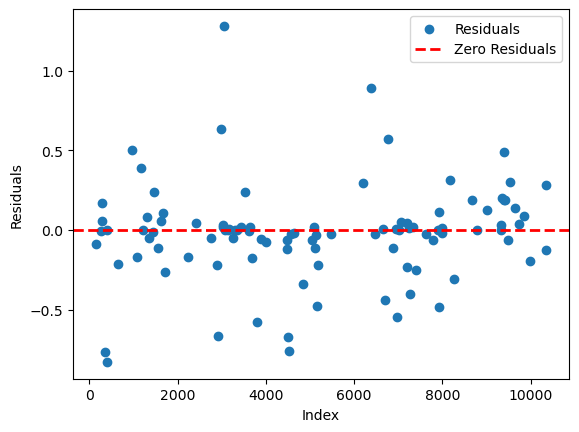

In [203]:
residuals = y_pred_subset - y_test_subset

plt.scatter(y_test_subset.index, residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Residuals')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

### Saving the model for future predictions

In [204]:
joblib.dump(TraSat, 'TraSat.joblib')

['TraSat.joblib']

In [205]:
TraSat_loaded = joblib.load('TraSat.joblib')

# Using an API to access Nutritional Information of popular meals

In [206]:
api_key = 'RHLVLnd9F3QueMUuvC93NtfgkgBSLD2BtP4LyD6s'
base_url = 'https://api.nal.usda.gov/fdc/v1/foods/search'

def get_nutrient_info(dish_name):
    params = {
        'query': dish_name,
        'pageSize': 1,  # limiting the results to one entry
        'api_key': api_key
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        if data['totalHits'] > 0:
            # extracting nutrient information for the first entry
            food = data['foods'][0]
            nutrient_info = f"Food: {food['description']}\n"
            for nutrient in food['foodNutrients']:
                nutrient_info += f"{nutrient['nutrientName']}: {nutrient['value']} {nutrient['unitName']}\n"
            nutrient_info += '-' * 30 + "\n"
            return nutrient_info
        else:
            return "No results found.\n"
    else:
        return f"Error: {response.status_code}\n"


In [207]:
nutrient_c = ['Seq_num', 'Food type', 'Vit-A (mg)', 'Alpha-carotene (mg)', 'Beta-carotene (mg)', 'Vit-C (mg)', 
             'Calcium (mg)', 'Iron (mg)', 'Caffeine (mg)', 'Alcohol (mg)', 'heme-iron-adj']

In [208]:
nutri_info = get_nutrient_info('mac and cheese')

In [209]:
nutri_lines = nutri_info.strip().split('\n')

# Create a dictionary to store nutrient data
nutrient_data = {}

# Parse each line and populate the dictionary
for line in nutri_lines[1:]:  # Skip the first line ('Food: ...')
    if ':' in line:
        nutrient, value = line.split(': ', 1)  # Split at the first occurrence of ':'
        nutrient_data[nutrient] = [value]

# Create a DataFrame from the dictionary
df = pd.DataFrame(nutrient_data)


In [210]:
df.head()

,Protein,Total lipid (fat),"Carbohydrate, by difference",Energy,"Alcohol, ethyl",Water,Caffeine,Theobromine,"Sugars, total including NLEA","Fiber, total dietary",...,PUFA 20:4,PUFA 22:6 n-3 (DHA),MUFA 16:1,PUFA 18:4,MUFA 20:1,PUFA 20:5 n-3 (EPA),MUFA 22:1,PUFA 22:5 n-3 (DPA),"Fatty acids, total monounsaturated","Fatty acids, total polyunsaturated"
0,3.26 G,1.86 G,20.1 G,110 KCAL,0.0 G,73.8 G,0.0 MG,0.0 MG,2.33 G,0.5 G,...,0.0 G,0.0 G,0.0 G,0.0 G,0.0 G,0.0 G,0.0 G,0.0 G,0.462 G,0.564 G


In [211]:
pd.set_option('display.max_columns', None)

In [212]:
# Define a custom function to process each cell
def process_cell(cell):
    value, unit = cell.split(' ')
    value = float(value)
    
    if unit == 'G':
        value *= 1000
    elif unit == 'UG':
        value /= 1000
    
    return value

# Apply the custom function 

# Apply the custom function to each cell in the DataFrame
df = df.applymap(process_cell)

# Remove the units from the DataFrame
df = df.applymap(lambda x: x if isinstance(x, (int, float)) else None)

In [213]:
df.head()

,Protein,Total lipid (fat),"Carbohydrate, by difference",Energy,"Alcohol, ethyl",Water,Caffeine,Theobromine,"Sugars, total including NLEA","Fiber, total dietary","Calcium, Ca","Iron, Fe","Magnesium, Mg","Phosphorus, P","Potassium, K","Sodium, Na","Zinc, Zn","Copper, Cu","Selenium, Se",Retinol,"Vitamin A, RAE","Carotene, beta","Carotene, alpha",Vitamin E (alpha-tocopherol),Vitamin D (D2 + D3),"Cryptoxanthin, beta",Lycopene,Lutein + zeaxanthin,"Vitamin C, total ascorbic acid",Thiamin,Riboflavin,Niacin,Vitamin B-6,"Folate, total",Vitamin B-12,"Choline, total",Vitamin K (phylloquinone),Folic acid,"Folate, food","Folate, DFE","Vitamin E, added","Vitamin B-12, added",Cholesterol,"Fatty acids, total saturated",SFA 4:0,SFA 6:0,SFA 8:0,SFA 10:0,SFA 12:0,SFA 14:0,SFA 16:0,SFA 18:0,MUFA 18:1,PUFA 18:2,PUFA 18:3,PUFA 20:4,PUFA 22:6 n-3 (DHA),MUFA 16:1,PUFA 18:4,MUFA 20:1,PUFA 20:5 n-3 (EPA),MUFA 22:1,PUFA 22:5 n-3 (DPA),"Fatty acids, total monounsaturated","Fatty acids, total polyunsaturated"
0,3260.00,1860.00,20100.00,110.00,0.00,73800.00,0.00,0.00,2330.00,500.00,95.00,0.67,15.00,93.00,99.00,259.00,0.36,0.06,0.01,0.03,0.03,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.24,0.16,0.99,0.04,0.04,0.00,9.70,0.00,0.04,0.00,0.07,0.00,0.00,2.00,799.00,0.00,0.00,0.00,0.00,0.00,114.00,535.00,151.00,462.00,564.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,462.00,564.00


In [214]:
print(nutri_info)

Food: Macaroni or noodles with cheese, Easy Mac type
Protein: 3.26 G
Total lipid (fat): 1.86 G
Carbohydrate, by difference: 20.1 G
Energy: 110 KCAL
Alcohol, ethyl: 0.0 G
Water: 73.8 G
Caffeine: 0.0 MG
Theobromine: 0.0 MG
Sugars, total including NLEA: 2.33 G
Fiber, total dietary: 0.5 G
Calcium, Ca: 95.0 MG
Iron, Fe: 0.67 MG
Magnesium, Mg: 15.0 MG
Phosphorus, P: 93.0 MG
Potassium, K: 99.0 MG
Sodium, Na: 259 MG
Zinc, Zn: 0.36 MG
Copper, Cu: 0.062 MG
Selenium, Se: 13.5 UG
Retinol: 26.0 UG
Vitamin A, RAE: 27.0 UG
Carotene, beta: 1.0 UG
Carotene, alpha: 0.0 UG
Vitamin E (alpha-tocopherol): 0.04 MG
Vitamin D (D2 + D3): 0.0 UG
Cryptoxanthin, beta: 0.0 UG
Lycopene: 0.0 UG
Lutein + zeaxanthin: 4.0 UG
Vitamin C, total ascorbic acid: 0.0 MG
Thiamin: 0.236 MG
Riboflavin: 0.16 MG
Niacin: 0.992 MG
Vitamin B-6: 0.036 MG
Folate, total: 41.0 UG
Vitamin B-12: 0.22 UG
Choline, total: 9.7 MG
Vitamin K (phylloquinone): 0.1 UG
Folic acid: 37.0 UG
Folate, food: 3.0 UG
Folate, DFE: 66.0 UG
Vitamin E, added: 0.

In [215]:
# Define the nutrient columns you want to extract
nutrient_columns = ['Vitamin A, RAE', 'Carotene, alpha', 'Carotene, beta','Vitamin C, total ascorbic acid', 
                    'Calcium, Ca', 'Iron, Fe', 'Caffeine', 'Alcohol, ethyl']

# Create a new DataFrame with the specified columns
nutrient_c = ['Vit-A (mg)', 'Alpha-carotene (mg)', 'Beta-carotene (mg)', 'Vit-C (mg)',
              'Calcium (mg)', 'Iron (mg)', 'Caffeine (mg)', 'Alcohol (mg)', 'heme-iron-adj']
new_df = pd.DataFrame(columns=nutrient_c)

# Map nutrient columns from the original DataFrame to the new DataFrame
for nutrient_col, new_col in zip(nutrient_columns, nutrient_c):
    new_df[new_col] = df[nutrient_col].apply(lambda x: float(x.split(' ')[0]) if isinstance(x, str) and ' ' in x else float(x) if isinstance(x, (int, float)) else 0)

# Manually add the 'heme-iron-adj' column
new_df['heme-iron-adj'] = [1] # Replace these values with your actual data

In [216]:
new_df

,Vit-A (mg),Alpha-carotene (mg),Beta-carotene (mg),Vit-C (mg),Calcium (mg),Iron (mg),Caffeine (mg),Alcohol (mg),heme-iron-adj
0,0.03,0.00,0.00,0.00,95.00,0.67,0.00,0.00,1


# Making predictions using the developed models - from API data

In [217]:
# Bioavailability prediction for Mac and Cheese as an example
prediction1 = FerriMetric_loaded.predict(new_df)[0]
print("The bioavailability of iron in this meal of Mac and Cheese is {:.2f} mg".format(prediction1))

The bioavailability of iron in this meal of Mac and Cheese is -63.49 mg


In [218]:
# Sample values to demonstrate the use of TraSat predictor
colss = ['Iron-Serum (ug/dL)', 'UIBC (ug/dL)', 'TIBC (ug/dL)']
tra_df = pd.DataFrame(columns = colss)
values = [81.0, 327.0, 409.0]
tra_df['Iron-Serum (ug/dL)'] = [values[0]]
tra_df['UIBC (ug/dL)'] = [values[1]]
tra_df['TIBC (ug/dL)'] = [values[2]]

In [219]:
# Transferrin saturation prediction example with random data.
prediction2 = TraSat_loaded.predict(tra_df)[0]
print("The Transferrin Saturation for this patient is {:.2f} %".format(prediction2))

The Transferrin Saturation for this patient is 19.99 %
